<a href="https://colab.research.google.com/github/zinoubm/Upwork_Portfolio/blob/main/Poverty_Level_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading The Data
The data for this project is Downloaded from kaggle(A Famous platform for Data Sience), If you want to reproduce this note book follow the steps explained in [this article](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) .

After downloading your kaggle credentials, upload the **kaggle.json** file to your google drive in a folder called kaggle.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Kaggle/kaggle.json' kaggle.json

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download costa-rican-household-poverty-prediction

In [ ]:
! unzip /content/costa-rican-household-poverty-prediction.zip -d /content/data

Now we will import the needed libraries.

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Introduction

The Inter-American Development Bank is asking the Kaggle community for help with income qualification for some of the world's poorest families. Are you up for the challenge?

To improve on PMT, the IDB (the largest source of development financing for Latin America and the Caribbean) has turned to the Kaggle community. They believe that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.

Beyond Costa Rica, many countries face this same problem of inaccurately assessing social need. If Kagglers can generate an improvement, the new algorithm could be implemented in other countries around the world.

## Metrics and Evaluation

In this notebook we will use two metrics for our model performance measurment.
The first one is the **macro-f1-score**. Despite being inapropriate for this dataset(because the data is squed), we will use it because it's the one that the original competetion for this notebook used.
The second one is **weighted-f1-score**, It's more apropriate for unbalenced data.

## Overview

 * #### Data Exploration
 * #### Label Distribution
 * #### Integer Columns
 * #### Float Columns
 * #### Object Columns
 * #### Feature Engeniering and Data Preprocessing
 * #### Data Aggregation
 * #### Initial Model Set Up
 * #### Hyper Parameter Tuning
 * #### Conclusion
 

In [ ]:
# reading the data
training = pd.read_csv("/content/data/train.csv")
testing = pd.read_csv("/content/data/test.csv")

In [ ]:
# datashape
nrow, ncol = training.shape
print('The data has' , nrow, "rows and", ncol, 'columns.')

The data has 9557 rows and 143 columns.


In [ ]:
training.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


We can see the the labels in this dataset are imbalence, this is where the **weighted-f1-score** comes in handy.

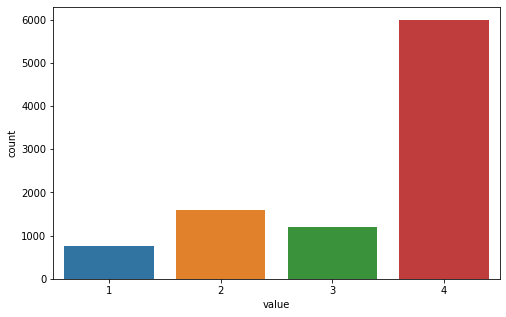

In [ ]:
# target distribution
plt.figure(figsize=(8,5))
labels_dist = training['Target'].value_counts().rename_axis('value').reset_index(name='count')
sns.barplot(data=labels_dist, x="value", y="count")
plt.show()

Also Some of the rows are misslabeld, let's see how many of these we have.

In [ ]:
by_idhogar = training.copy().groupby("idhogar")
correct_labels = by_idhogar.Target.apply(lambda x: len(x.unique()) == 1)
print(f"There are {len(correct_labels[correct_labels == False])} houshlds that values don't match")

There are 85 houshlds that values don't match


We find mislabeled examples by comparing the label of the example and the label of household head, If they don't match then the given example is misslabeld, To address this essue we replace the wrong labels by the labels of the household.
We also need the check if there are any housholds without a head.

In [ ]:
correct_labels = by_idhogar.apply(lambda x: any(x['parentesco1'] == 1))
house_holds_without_head = correct_labels[correct_labels == False]
print(f'There are {len(house_holds_without_head)} house holds without head.')

There are 15 house holds without head.


The rules for fixing the labels are simple:
* if the individual's label dont match the label for the head of the House hold replace it by the label of the head of the House hold.
* if there's no head of the House hold replace with None for later imputation.

In [ ]:
def correct_label(house_hold):
    super_label = house_hold[house_hold['parentesco1'] == 1]['Target']
    if len(super_label) == 0:
        house_hold['Target'] = None
    else:
        house_hold['Target'] = super_label.values[0]
    return house_hold
    
training = by_idhogar.apply(correct_label)

We need to impute missing labels.

In [ ]:
median_value = training['Target'].median().astype(np.int32)
training['Target'].fillna(median_value, inplace=True)

Here we can see that 0 examples are misslabeled.

In [ ]:
res = training.groupby("idhogar").Target.apply(lambda x: len(x.unique()) == 1)
print(f"There are {len(res[res == False])} houshlds that values don't match")

There are 0 houshlds that values don't match


Now we need to separate columns by their data type

In [ ]:
integers = ['int16', 'int32', 'int64']
floats = ['float16', 'float32', 'float64']
objects = ['object']

integer_columns = training.select_dtypes(include=integers).columns
float_columns = training.select_dtypes(include=floats).columns
object_columns = training.select_dtypes(include=objects).columns

## Integer columns
Let's start by analysing columns with Integer data.

Let's see the distribution for 9 columns chosen randomly.

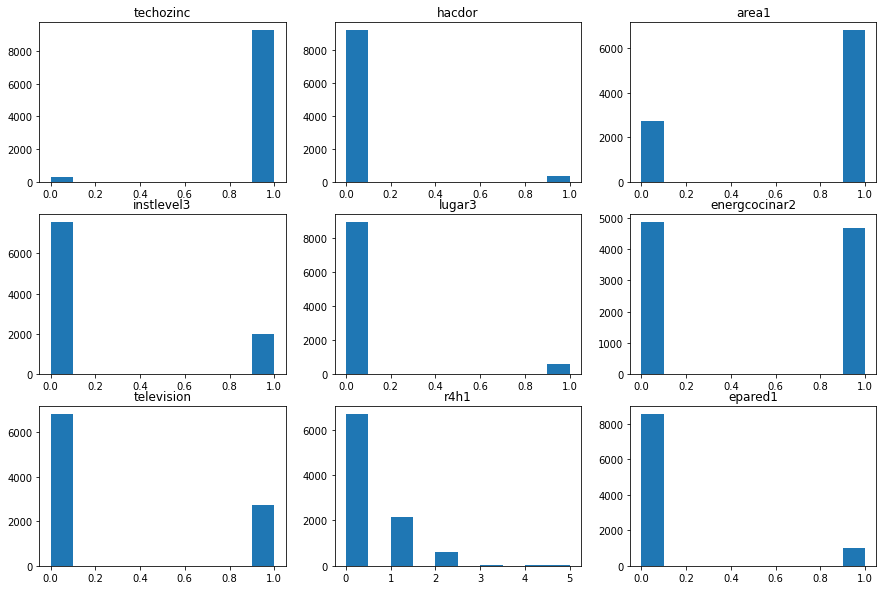

In [ ]:
import random
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for ax, feature in zip(fig.get_axes(), random.sample(list(integer_columns), 9)):
    data = training[feature]
    ax.hist(data)
    ax.set_title(feature)

This bar plot shows us the count of unique values in each integer column, We can see the majority of our data is binary.

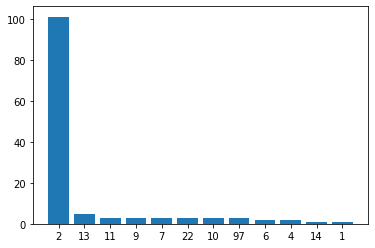

In [ ]:
integer_value_counts = training[integer_columns].apply(lambda x: len(x.value_counts()), axis = 0).value_counts()
labels = [str(x) for x in integer_value_counts.index]
plt.bar(labels, integer_value_counts.values)
plt.show()

## Float columns

Now let's take a look at float columns.

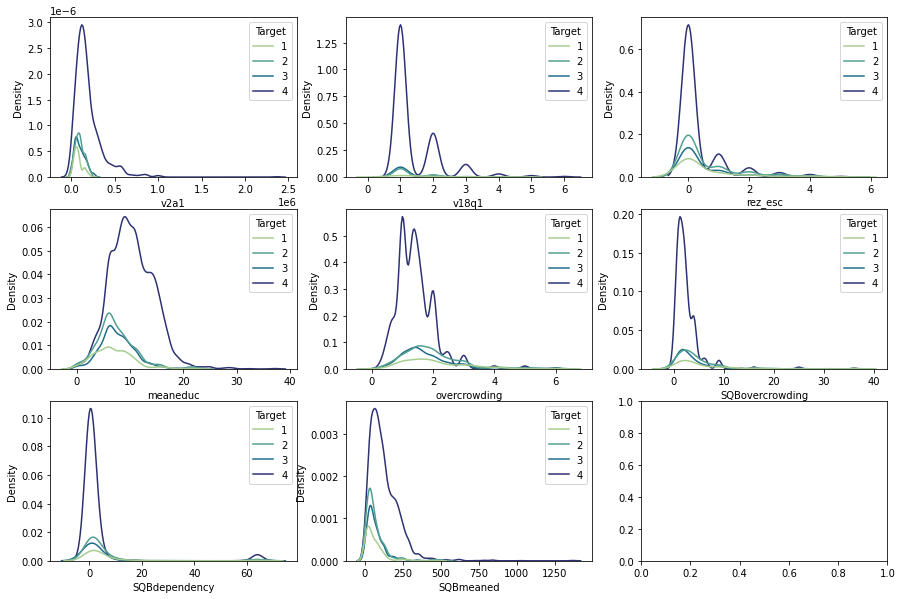

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for ax, feature in zip(fig.get_axes(), float_columns):
    sns.kdeplot(ax=ax, data=training, x=feature, hue='Target',  palette="crest")

## Missing values

We have 5 columns with missing values, two of them are so close to 0 so we'll just impute them, the other columns needs some investigation.

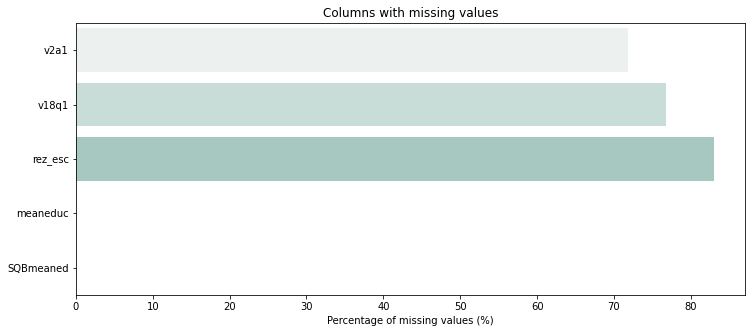

In [ ]:
data = (training.isnull().sum()/nrow)*100
data = data.loc[data>0]
fig = plt.figure(figsize = (12, 5))
sns.barplot(x=data.values, y=data.index,
            orient = 'h', palette = 'light:#5A9')
plt.title('Columns with missing values')
plt.xlabel('Percentage of missing values (%)')
plt.show()

From the data description of the competition the missing values in columns **dependency**, **edjefe** and **edjefa**, have to be replaced by **1** for **yes**, and **0** for **no**.

In [ ]:
mapper = {"yes": '0',
          "no": '1'}

for col in ['dependency', 'edjefe', 'edjefa']:
    training[col] = training[col].replace(mapper).astype(np.float64)

v2a1 is the **Monthly rent payment**, We'll check if there are some people that owns their houses, maybe this will explain the appearance of missing values (you don't pay rent for a house that you own)

In [ ]:
house_ownership = training[['v2a1', 'tipovivi1', 'tipovivi2', 'tipovivi3']]
house_ownership['rentNa'] = house_ownership['v2a1'].isna()
house_ownership['owned'] =house_ownership['tipovivi1'].eq(1) | house_ownership['tipovivi2'].eq(1)
res = house_ownership[house_ownership['v2a1'].isna()]

pd.crosstab(house_ownership.rentNa,house_ownership.owned)

owned,False,True
rentNa,,
False,1736,961
True,949,5911


We can see from the little table, speceficly in the second row (where renNa is true) that there are ~6000 missing values where people own their houses, So our assumption holds true. There are ~1000 missing values that will be left for mediane imputation, and the missing values where the house is owned, will be filled by 0.

In [ ]:
cond = training['v2a1'].isna() & (house_ownership['tipovivi1'].eq(1) | house_ownership['tipovivi2'].eq(1))
training['v2a1'][cond] = 0
median_value = training['v2a1'].median()
training['v2a1'].fillna(median_value, inplace=True)

we can see now that 0% of our data is missing


In [ ]:
training['v2a1'].isna().sum()/len(training['v2a1']) * 100

0.0

v1Artist8q1 is the number of tablets in a household. Lets assume that Nan means 0 and not having a tablet is more common and check our assumptions.

In [ ]:
training['v18q1'].fillna(0, inplace=True)

We can see that our assumptions holds true, 0 is the most vued case.

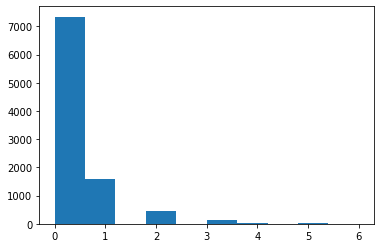

In [ ]:
plt.hist(training['v18q1'])
plt.show()

rez_esc is the **Years behind in school**, Maybe these households simply don't have children in shcool. We can see when we describe our data that min is **7** and max **17**, The data description states that This variable is only defined for children between 7 and 17. So missing values will be replaced with 0.

In [ ]:
training.loc[training['rez_esc'].notnull()]['age'].describe()

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [ ]:
training['rez_esc'].fillna(0, inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer
cols = ['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(training[cols])
training[cols] = imp_mean.fit_transform(training[cols])

In [ ]:
Y = training['Target']
training.drop(columns=['Target'], inplace=True)

## Feature Engeniering and Data Preprocessing

Converting **One Hot Encoding** to **Label Encoding**.

In [ ]:
prefixes = ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu', 
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco', 
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']
    
for p in prefixes:
    cols = []
    for col in training.columns:
        if col.startswith(p):
            cols.append(col)
            
    if not (training[cols].apply(axis = 1, func = sum) != 1).any():
        training[p] = training[cols].apply(axis=1, func=np.argmax)
        training.drop(columns=cols, inplace=True)

We will generate some features that may help our Prediction model
* Number of rooms/ number of people
* Mobile fraction
* Tablet fraction
* Children fraction
* Adult fraction

In [ ]:
training['people_per_room'] = training['r4t3'] / training['rooms']
training['mobile_fraction'] = training['qmobilephone'] / training['r4t3']
training['tablet_fraction'] = training['v18q1'] / training['r4t3']
training['children_fraction'] = training['hogar_nin'] / training['r4t3']
training['adult_fraction'] = training['hogar_adul'] / training['r4t3']

## Data Aggregation

In [ ]:
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

integer_columns = training.select_dtypes(include=integers).columns
float_columns = training.select_dtypes(include=floats).columns

train_agg = training[['idhogar', *float_columns, *integer_columns]].groupby('idhogar').agg(['min', 'max', 'sum', 'count', range_])

In [ ]:
new_col = []
for col in train_agg.columns.levels[0]:
    for stat in train_agg.columns.levels[1]:
        new_col.append(f'{col}-{stat}')

train_agg.columns = new_col

The aggregation process generated a lot of collumns, We will remove columns that have over 0.95 correlation.

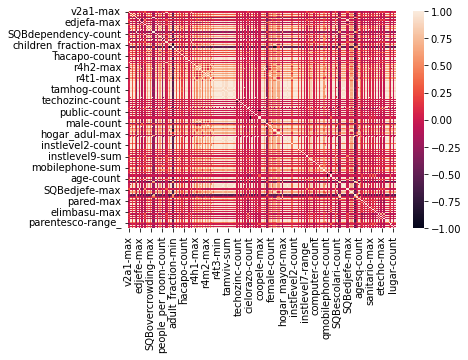

In [ ]:
corr_matrix = train_agg.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

sns.heatmap(corr_matrix.loc[to_drop, to_drop])

# dropping correlated columns
train_agg.drop(columns=to_drop, inplace=True)

In [ ]:
# dropping Id and idhogar for training
training.drop(columns=['Id', 'idhogar'], inplace=True)

In order for our workflow to be more organized, The **pipe_line** function will assemble all of our preprocessing.

In [ ]:
def correct_label(house_hold):
    super_label = house_hold[house_hold['parentesco1'] == 1]['Target']
    if len(super_label) == 0:
        house_hold['Target'] = None
    else:
        house_hold['Target'] = super_label.values[0]
    return house_hold

def pipe_line(df, to_drop, is_train=True):
    
    if is_train:
        by_idhogar = df.copy().groupby("idhogar")
        df = by_idhogar.apply(correct_label)
        
        median_value = df['Target'].median().astype(np.int32)
        df['Target'].fillna(median_value, inplace=True)
    
    #  mapping words to numbers
    mapper = {"yes": '0',
              "no": '1'}

    for col in ['dependency', 'edjefe', 'edjefa']:
        df[col] = df[col].replace(mapper).astype(np.float64)
        
    # diferent columns
    integers = ['int16', 'int32', 'int64']
    floats = ['float16', 'float32', 'float64']
    objects = ['object']

    integer_columns = df.select_dtypes(include=integers).columns
    float_columns = df.select_dtypes(include=floats).columns
    object_columns = df.select_dtypes(include=objects).columns
    
    # fixing the rent variable
    house_ownership = df[['v2a1', 'tipovivi1', 'tipovivi2', 'tipovivi3']]

    cond = df['v2a1'].isna() & (house_ownership['tipovivi1'].eq(1) | house_ownership['tipovivi2'].eq(1))
    df['v2a1'][cond] = 0
    median_value = df['v2a1'].median()
    df['v2a1'].fillna(median_value, inplace=True)
    
    
    # fixing number of tablets
    df['v18q1'].fillna(0, inplace=True)
    
    
    # training['rez_esc'].fillna(0, inplace=True)
    df['rez_esc'].fillna(0, inplace=True)
    
    from sklearn.impute import SimpleImputer
    cols = ['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean.fit(df[cols])
    df[cols] = imp_mean.fit_transform(df[cols])
    
    
    # convert one hot encodig to label encoding
    prefixes = ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu', 
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco', 
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']

    for p in prefixes:
        cols = []
        for col in df.columns:
            if col.startswith(p):
                cols.append(col)

        if not (df[cols].apply(axis = 1, func = sum) != 1).any():
            df[p] = df[cols].apply(axis=1, func=np.argmax)
            df.drop(columns=cols, inplace=True)


    # some standard features
    df['people_per_room'] = df['r4t3'] / df['rooms']
    df['mobile_fraction'] = df['qmobilephone'] / df['r4t3']
    df['tablet_fraction'] = df['v18q1'] / df['r4t3']
    df['children_fraction'] = df['hogar_nin'] / df['r4t3']
    df['adult_fraction'] = df['hogar_adul'] / df['r4t3']
    
    # data aggregation
    range_ = lambda x: x.max() - x.min()
    range_.__name__ = 'range_'
    df_columns = df.columns
    df_columns = [col for col in df_columns if col != 'Target']
    
    integer_columns = df[df_columns].select_dtypes(include=integers).columns
    float_columns = df[df_columns].select_dtypes(include=floats).columns
    cols_to_agg = ['idhogar', *float_columns, *integer_columns]
    

    df_agg = df[cols_to_agg].groupby('idhogar').agg(['min', 'max', 'sum', 'count', range_])
    
    
    if is_train:
        df_agg_target = df[['idhogar','Target']].groupby('idhogar').agg(['max'])
    else:
        df_agg_target = None

    new_col = []
    for col in df_agg.columns.levels[0]:
        for stat in df_agg.columns.levels[1]:
            new_col.append(f'{col}-{stat}')

    df_agg.columns = new_col

    # dropping correlated columns
    df_agg.drop(columns=to_drop, inplace=True)

    return df_agg, df_agg_target

Let's reload the training and testing set and preprocess them.

In [ ]:
training = pd.read_csv("/content/data/train.csv")
testing = pd.read_csv("/content/data/test.csv")

preprocessed_training = pipe_line(training, to_drop, is_train=True)
preprocessed_testing = pipe_line(testing, to_drop, is_train=False)

In [ ]:
X, y = preprocessed_training

## Preparing the data for training and testing

In this notebood we will focus on **XG-Boost** model, as it shown very goood results in kaggle.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=314)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

rf = RandomForestClassifier(random_state = 3)
cv = cross_val_score(rf,X_train,y_train,cv=5, scoring='f1_macro')
print("Cross validation results for macro f1 score")
print(cv)
print(cv.mean())

print('------------------------------------------------------------')


rf = RandomForestClassifier(random_state = 3)
cv = cross_val_score(rf,X_train,y_train,cv=5, scoring='f1_weighted')
print("Cross validation results for weighted f1 score")
print(cv)
print(cv.mean())

Cross validation results for macro f1 score
[0.37607062 0.3368442  0.36769722 0.37217137 0.33953743]
0.35846416565614153
------------------------------------------------------------
Cross validation results for weighted f1 score
[0.63160726 0.60696287 0.63792539 0.61769581 0.60882524]
0.6206033126135949


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


rf = RandomForestClassifier(random_state = 3)
cv = cross_val_score(rf,X_train,y_train,cv=5, scoring='f1_macro')
print("Cross validation results for macro f1 score")
print(cv)
print(cv.mean())

print('------------------------------------------------------------')

rf = RandomForestClassifier(random_state = 3)
cv = cross_val_score(rf,X_train,y_train,cv=5, scoring='f1_weighted')
print("Cross validation results for weighted f1 score")
print(cv)
print(cv.mean())

Cross validation results for macro f1 score
[0.37607062 0.3368442  0.36769722 0.37217137 0.33953743]
0.35846416565614153
------------------------------------------------------------
Cross validation results for weighted f1 score
[0.63160726 0.60696287 0.63792539 0.61769581 0.60882524]
0.6206033126135949


## XG-Boost

In [ ]:
from xgboost import XGBClassifier

xg_boost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1,
              #  monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

xg_boost.fit(X_train, y_train-1,  verbose=False)
y_pred = xg_boost.predict(X_test) + 1

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print("Cross validation results for macro f1 score")
print(f1_score(y_test, y_pred, average='macro'))
print('-----------------------------------------')
print("Cross validation results for weighted f1 score")
print(f1_score(y_test, y_pred, average='weighted'))

Cross validation results for macro f1 score
0.40184495248435603
-----------------------------------------
Cross validation results for weighted f1 score
0.628726107471029


## Hyper Parameter Tuning
For this task we will use **HyperOpt** a very powerful optimization library.

In [ ]:
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn import metrics

In [ ]:
def custom_metric(y_test, y_pred):
    loss = f1_score(y_test, y_pred, average='macro')
    return loss

For **hyperopt** to work we need to define a **space** (which is a range that the optimization algoritms will search for final hyper parameters values), and an **objective** function (which returns the loss for the optimzation algorithms).

In [ ]:
space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

def objective(space):
    xg_boost = XGBClassifier(max_depth= int(space['max_depth']),learning_rate = space['learning_rate'], 
                            reg_alpha = space['reg_alpha'], reg_lambda = space['reg_lambda'],
                            colsample_bytree = space['colsample_bytree'])

    xg_boost.fit(X_train, y_train-1, verbose=False)

    y_pred = xg_boost.predict(X_test) + 1
    loss = f1_score(y_test, y_pred, average='macro')
    return {'loss': - loss, 'status': STATUS_OK }
    
trials = Trials()

params = fmin(fn = objective,
                    space = space,
                    algo = tpe.suggest,
                    max_evals = 50,
                    trials = Trials(),
                    verbose = 0
                   )

100%|██████████| 50/50 [07:59<00:00,  9.59s/it, best loss: -0.39638709717357967]


Final model using optimized parameters.

In [ ]:

model = XGBClassifier(boosting_type = params['boosting_type'], limit_max_depth = params['limit_max_depth'], max_depth= int(params['max_depth']),
                            num_leaves = params['num_leaves'], learning_rate = params['learning_rate'], subsample_for_bin = params['subsample_for_bin'],
                            min_child_samples = params['min_child_samples'], reg_alpha = params['reg_alpha'], reg_lambda = params['reg_lambda'],
                            colsample_bytree = params['colsample_by_tree'])

model.fit(X_train, y_train-1, verbose=False)

y_pred = model.predict(X_test) + 1

print("Cross validation results for macro f1 score")
print(f1_score(y_test, y_pred, average='macro'))
print('-----------------------------------------')
print("Cross validation results for weighted f1 score")
print(f1_score(y_test, y_pred, average='weighted'))

Cross validation results for macro f1 score
0.39638709717357967
-----------------------------------------
Cross validation results for weighted f1 score
0.6294432971727685


# Results
As we can see from the last cell, our final scores are:
* **0.63** for **Weighted f1-score**
* **0.40** for **macro f1-score**

Which are very descent scores for this kind of datasets.